In [9]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from scipy.optimize import minimize



eta = 0.9999
p_dc = 1e-6

# Normal CHSH Score:

###  parametrized M  for T1 = T2 =T

$$ M = T* R_{\alpha - \beta}$$


### Let $g(i_1, i_2, j_1, j_2) = \left\langle G_{i_1}^{(a_h)} \otimes G_{i_2}^{(a_v)} \otimes G_{j_1}^{(b_h)} \otimes G_{j_2}^{(b_v)} \right\rangle$ be a function with binary inputs defined in the paper. The distribution  $p(a_1, a_2, b_1, b_2)$ can be calculated as:

$$ p(a_1, a_2, b_1, b_2) = \sum_{i_1 \in [0, a_1]} \sum_{i_2 \in [0, a_2]} \sum_{j_1 \in [0, b_1]} \sum_{j_2 \in [0, b_2]} g(i_1, i_2, j_1, j_2) \cdot (-1)^{(a_1 + a_2 + b_1 + b_2) - (i_1 + i_2 + j_1 + j_2)}$$

In [10]:
def M_2x2_parametrized(params):
    
    
    [alpha, beta, T ] = params
    
    gamma = alpha - beta
    
    R = np.array([
        [np.cos(gamma), -np.sin(gamma)],
        [np.sin(gamma),  np.cos(gamma)]])
    
    
    #D = np.diag([l0, l1])
    
    # Compute m' = D_a * m * D_b
    #M = R1 @ D @ R2.T
    M = T * R
    
    return M
    


In [11]:
def N(m):
    """
    Compute N(m) =  ((1 - s1^2) * (1 - s2^2)),
    where s1 and s2 are the singular values of the matrix m.
    """
    # Ensure the input is a 2x2 matrix
    #if m.shape != (2, 2):
    #    raise ValueError("Input matrix m must be 2x2.")
    
    # Compute the singular values of the matrix m
    singular_values = np.linalg.svd(m, compute_uv=False)
    s1, s2 = singular_values[:2]  # Get the first two singular values (for 2x2)
    
    # Compute N(m)
    n = (1 - s1**2) * (1 - s2**2)
    
    return n

In [12]:
def g(i1, i2, j1, j2, m):
    """
    Compute g(i1, i2, j1, j2) = N(m) / N(m'),
    where m' = D_a * m * D_b, and D_a and D_b are diagonal matrices
    defined based on i1, i2, j1, j2.
    
    Parameters:
        i1, i2, j1, j2: int
            Binary inputs (0 or 1) to define diagonal matrices D_a and D_b.
        m: numpy.ndarray
            A 2x2 matrix.
    
    Returns:
        float
            The computed value of g(i1, i2, j1, j2).
    """
    # Ensure inputs are binary
    if any(x not in {0, 1} for x in [i1, i2, j1, j2]):
        raise ValueError("Inputs i1, i2, j1, and j2 must be binary (0 or 1).")
    
    # Ensure the matrix is 2x2
    #if m.shape != (2, 2):
    #    raise ValueError("Matrix m must be 2x2.")
    
    # Define the diagonal matrices D_a and D_b
    
    #g_x = lambda x: 1 - eta * (1 - x)
    g_x = lambda x: np.sqrt(1 - eta * (1 - x))
    
    D_a = np.diag([g_x(i1), g_x(i2)])
    D_b = np.diag([g_x(j1), g_x(j2)])
    
    # Compute m' = D_a * m * D_b
    m_prime = D_a @ m @ D_b
    
    # Compute N(m) and N(m')
    Nm = N(m)
    Nm_prime = N(m_prime)
    
    # Check for division by zero
    #if Nm_prime == 0:
    #    raise ValueError("N(m') is zero, the computation is undefined.")
    
    return ((1-p_dc)**(4-i1-i2-j1-j2))*(Nm/Nm_prime)  #(Nm_prime +0.000000001)



In [13]:
def p(a1, a2, b1, b2, m):
    
    # Ensure inputs are binary
    if any(x not in {0, 1} for x in [a1, a2, b1, b2]):
        raise ValueError("Inputs a1, a2, b1, and b2 must be binary (0 or 1).")
    
    result = 0
    total_sum = a1 + a2 + b1 + b2

    # Iterate over all combinations of i1, i2, j1, j2
    for i1 in range(a1 + 1):
        for i2 in range(a2 + 1):
            for j1 in range(b1 + 1):
                for j2 in range(b2 + 1):
                    # Compute the power of -1
                    sign = (-1) ** (total_sum - (i1 + i2 + j1 + j2))
                    # Add to the result
                    result += g(i1, i2, j1, j2, m) * sign
    
    return np.round(result,8)


In [14]:
# Local mappings for Alice and Bob
def alice_mapping(a1, a2):
    # valid terms
    if (a1, a2) == (0, 1):
        return 0
    elif (a1, a2) == (1, 0):
        return 1
    
    # not valid terms
    elif (a1, a2) == (0, 0):
        return 0
    elif (a1, a2) == (1, 1):
        return 0

def bob_mapping(b1, b2):
    # valid terms
    if (b1, b2) == (0, 1):
        return 0
    elif (b1, b2) == (1, 0):
        return 1
    
    # not valid terms
    elif (b1, b2) == (0, 0):
        return 0
    elif (b1, b2) == (1, 1):
        return 0

In [15]:
def CHSH_Score(params):
    
    [T, alpha0, alpha1, beta1] = params
    #beta0 = 0
    
    # Rxy
    R00 = np.array([
        [np.cos(alpha0), -np.sin(alpha0)],
        [np.sin(alpha0),  np.cos(alpha0)]])
    
    R01 = np.array([
        [np.cos(alpha0-beta1), -np.sin(alpha0-beta1)],
        [np.sin(alpha0-beta1),  np.cos(alpha0-beta1)]])
    
    R10 = np.array([
        [np.cos(alpha1), -np.sin(alpha1)],
        [np.sin(alpha1),  np.cos(alpha1)]])
    
    R11 = np.array([
        [np.cos(alpha1-beta1), -np.sin(alpha1-beta1)],
        [np.sin(alpha1-beta1),  np.cos(alpha1-beta1)]])
    
    M00 = T * R00
    M01 = T * R01
    M10 = T * R10
    M11 = T * R11
    
    
    #....................................................
    
    # Initialize q(a, b)
    q00 = {
        (0, 0): 0.0,
        (0, 1): 0.0,
        (1, 0): 0.0,
        (1, 1): 0.0}
    
    q01 = q00.copy()
    q10 = q00.copy()
    q11 = q00.copy()
    
    
    # Collect all possible combinations
    all_combinations = [(a1, a2, b1, b2) for a1 in [0, 1] for a2 in [0, 1]
                                         for b1 in [0, 1] for b2 in [0, 1]]

    # Compute q(a, b)
    # here we assume the same relabaling for all x,y inputs
    for a1, a2, b1, b2 in all_combinations:
        prob00 = p(a1, a2, b1, b2, M00)
        prob01 = p(a1, a2, b1, b2, M01)
        prob10 = p(a1, a2, b1, b2, M10)
        prob11 = p(a1, a2, b1, b2, M11)

        # Get local mappings for Alice and Bob
        a = alice_mapping(a1, a2)
        b = bob_mapping(b1, b2)

        q00[(a, b)] += prob00
        q01[(a, b)] += prob01
        q10[(a, b)] += prob10
        q11[(a, b)] += prob11
        
    avg_00 = q00[(0, 0)]+q00[(1, 1)]-q00[(0, 1)]-q00[(1, 0)]
    avg_01 = q01[(0, 0)]+q01[(1, 1)]-q01[(0, 1)]-q01[(1, 0)]
    avg_10 = q10[(0, 0)]+q10[(1, 1)]-q10[(0, 1)]-q10[(1, 0)]
    avg_11 = q11[(0, 0)]+q11[(1, 1)]-q11[(0, 1)]-q11[(1, 0)]
    
    CHSH_score = avg_00 + avg_01 + avg_10 - avg_11
    
    return -CHSH_score

### Optimization:

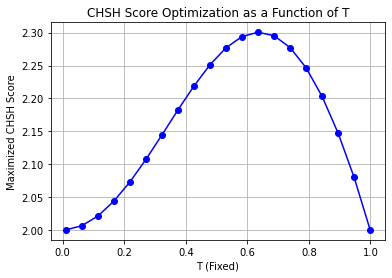

In [17]:
def optimize_for_fixed_T(T_fixed):
    # Objective function with T fixed
    def objective(variables):
        alpha0, alpha1, beta1 = variables
        return CHSH_Score([T_fixed, alpha0, alpha1, beta1])  # Negative for maximization

    # Initial guess for alpha0, alpha1, beta1
    init_param = np.random.uniform(0, 2 * np.pi, 3)

    # Bounds for the other parameters
    bounds = [(0, 2 * np.pi), (0, 2 * np.pi), (0, 2 * np.pi)]

    # Optimization
    result = minimize(
        objective,
        init_param,
        bounds=bounds,
        method='Powell',  # You can experiment with other methods
        options={'disp': False}
    )
    return -result.fun  # Return the maximized score

# Array of 50 fixed T values


grid = 20
T_values = np.linspace(0.01, 0.999, grid)
optimized_scores = np.zeros(grid)

# Store optimized scores for each T # repeat optimization 3 times ...


for i in range(grid):
    T = T_values[i]
    Best_val = 0
    for _ in range(3):
        new_val = optimize_for_fixed_T(T)
        if new_val > Best_val:
            Best_val = new_val
    optimized_scores[i] = Best_val
#optimized_scores = [optimize_for_fixed_T(T) for T in T_values]

# Plot the result
plt.plot(T_values, optimized_scores, marker='o', linestyle='-', color='b')
plt.xlabel('T (Fixed)')
plt.ylabel('Maximized CHSH Score')
plt.title('CHSH Score Optimization as a Function of T')
plt.grid(True)
plt.show()

# Plot Normal CHSH:

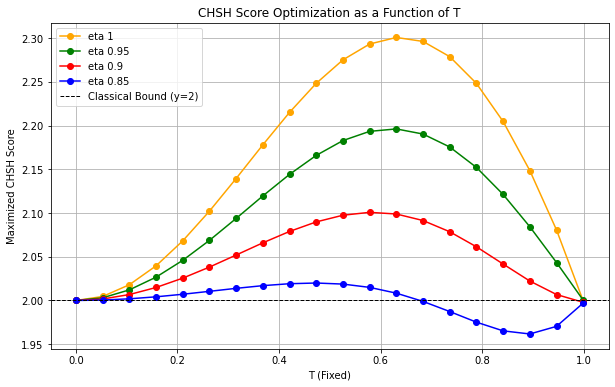

In [249]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(T_values, optimized_scores_1, marker='o', linestyle='-', color='orange',label = 'eta 1')
plt.plot(T_values, optimized_scores_95, marker='o', linestyle='-', color='g',label = 'eta 0.95')
plt.plot(T_values, optimized_scores_9, marker='o', linestyle='-', color='r',label = 'eta 0.9')
plt.plot(T_values, optimized_scores_85, marker='o', linestyle='-', color='b',label = 'eta 0.85')


# Add dashed line at y=2
plt.axhline(y=2, color='k', linestyle='--', linewidth=1, label='Classical Bound (y=2)')


plt.xlabel('T (Fixed)')
plt.ylabel('Maximized CHSH Score')
plt.title('CHSH Score Optimization as a Function of T')
plt.grid(True)
plt.legend()
plt.show()

# With post selection  (We post select on Alice being succesful)

In [18]:
def p_post_select(a1, a2, b1, b2, m):
    
    if a1==a2== 0:
        return 0
    
    p_fail = p(0, 0, 0, 0, m) + p(0, 0, 0, 1, m) + p(0, 0, 1, 0, m) + p(0, 0, 1, 1, m)
    
    return p(a1, a2, b1, b2, m)/(1-p_fail)

In [19]:
def CHSH_Score_post_select(params):
    
    [T, alpha0, alpha1, beta1] = params
    #beta0 = 0
    
    # Rxy
    R00 = np.array([
        [np.cos(alpha0), -np.sin(alpha0)],
        [np.sin(alpha0),  np.cos(alpha0)]])
    
    R01 = np.array([
        [np.cos(alpha0-beta1), -np.sin(alpha0-beta1)],
        [np.sin(alpha0-beta1),  np.cos(alpha0-beta1)]])
    
    R10 = np.array([
        [np.cos(alpha1), -np.sin(alpha1)],
        [np.sin(alpha1),  np.cos(alpha1)]])
    
    R11 = np.array([
        [np.cos(alpha1-beta1), -np.sin(alpha1-beta1)],
        [np.sin(alpha1-beta1),  np.cos(alpha1-beta1)]])
    
    M00 = T * R00
    M01 = T * R01
    M10 = T * R10
    M11 = T * R11
    
    
    #....................................................
    
    # Initialize q(a, b)
    q00 = {
        (0, 0): 0.0,
        (0, 1): 0.0,
        (1, 0): 0.0,
        (1, 1): 0.0}
    
    q01 = q00.copy()
    q10 = q00.copy()
    q11 = q00.copy()
    
    
    # Collect all possible combinations
    all_combinations = [(a1, a2, b1, b2) for a1 in [0, 1] for a2 in [0, 1]
                                         for b1 in [0, 1] for b2 in [0, 1]]

    # Compute q(a, b)
    # here we assume the same relabaling for all x,y inputs
    for a1, a2, b1, b2 in all_combinations:
        prob00 = p_post_select(a1, a2, b1, b2, M00)
        prob01 = p_post_select(a1, a2, b1, b2, M01)
        prob10 = p_post_select(a1, a2, b1, b2, M10)
        prob11 = p_post_select(a1, a2, b1, b2, M11)

        # Get local mappings for Alice and Bob
        a = alice_mapping(a1, a2)
        b = bob_mapping(b1, b2)

        q00[(a, b)] += prob00
        q01[(a, b)] += prob01
        q10[(a, b)] += prob10
        q11[(a, b)] += prob11
        
    avg_00 = q00[(0, 0)]+q00[(1, 1)]-q00[(0, 1)]-q00[(1, 0)]
    avg_01 = q01[(0, 0)]+q01[(1, 1)]-q01[(0, 1)]-q01[(1, 0)]
    avg_10 = q10[(0, 0)]+q10[(1, 1)]-q10[(0, 1)]-q10[(1, 0)]
    avg_11 = q11[(0, 0)]+q11[(1, 1)]-q11[(0, 1)]-q11[(1, 0)]
    
    CHSH_score = avg_00 + avg_01 + avg_10 - avg_11
    
    return -CHSH_score

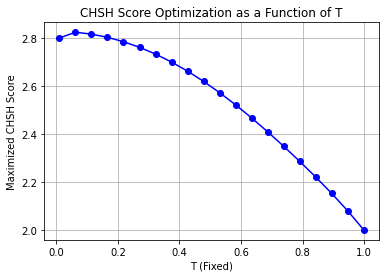

In [24]:
import matplotlib.pyplot as plt

def optimize_for_fixed_T(T_fixed):
    # Objective function with T fixed
    def objective(variables):
        alpha0, alpha1, beta1 = variables
        return CHSH_Score_post_select([T_fixed, alpha0, alpha1, beta1])  # Negative for maximization

    # Initial guess for alpha0, alpha1, beta1
    init_param = np.random.uniform(0, 2 * np.pi, 3)

    # Bounds for the other parameters
    bounds = [(0, 2 * np.pi), (0, 2 * np.pi), (0, 2 * np.pi)]

    # Optimization
    result = minimize(
        objective,
        init_param,
        bounds=bounds,
        method='Powell',  # You can experiment with other methods
        options={'disp': False}
    )
    return -result.fun  # Return the maximized score

# Array of 50 fixed T values


grid = 20
T_values = np.linspace(0.01, 0.999, grid)
optimized_scores_post_select = np.zeros(grid)

# Store optimized scores for each T # repeat optimization 3 times ...


for i in range(grid):
    T = T_values[i]
    Best_val = 0
    for _ in range(3):
        new_val = optimize_for_fixed_T(T)
        if new_val > Best_val:
            Best_val = new_val
    optimized_scores_post_select[i] = Best_val
#optimized_scores = [optimize_for_fixed_T(T) for T in T_values]


## add the CHSH Correction Terms

In [46]:
def Correction(T):
    m = M_2x2_parametrized([0.1,0.1,T])

    epsilon_a = p(0, 0, 0, 1, m) + p(0, 0, 1, 0, m) + p(0, 0, 1, 1, m) # P(a = fail , b = success)
    epsilon_b = p(0, 1, 0, 0, m) + p(1, 0, 0, 0, m) + p(1, 1, 0, 0, m) # P(a = success , b = fail)
    epsilon = epsilon_a + epsilon_b
    p_check_a = 1 - epsilon_a - p(0, 0, 0, 0, m) # P(a = success)

    #print(p_check_a)
    
    F = 1 - (epsilon*(2-epsilon)/p_check_a)
    C = 4*np.sqrt(1-F**2)
    
    return(C)

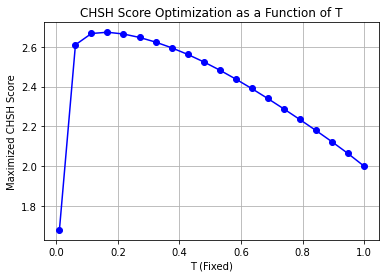

In [48]:
Correction_terms = np.array([Correction(T) for T in T_values]);
Corrected = optimized_scores_post_select-Correction_terms;


# Plot the result
plt.plot(T_values, Corrected, marker='o', linestyle='-', color='b')
plt.xlabel('T (Fixed)')
plt.ylabel('Maximized CHSH Score')
plt.title('CHSH Score Optimization as a Function of T')
plt.grid(True)
plt.show()

# Load data

In [66]:
# for p_dc = 0
corrected_995 = np.load("CHSH_eta_995.npz")["Corrected"]
corrected_997 = np.load("CHSH_eta_997.npz")["Corrected"]
corrected_999 = np.load("CHSH_eta_999.npz")["Corrected"]
corrected_9999 = np.load("CHSH_eta_9999.npz")["Corrected"]
corrected_1 = np.load("CHSH_eta_1.npz")["Corrected"]


# for p_dc = 10^-6
corrected_995_dc_6 = np.load("CHSH_eta_995_dc_6.npz")["Corrected"]
corrected_997_dc_6 = np.load("CHSH_eta_997_dc_6.npz")["Corrected"]
corrected_999_dc_6 = np.load("CHSH_eta_999_dc_6.npz")["Corrected"]
corrected_9999_dc_6 = np.load("CHSH_eta_9999_dc_6.npz")["Corrected"]
corrected_1_dc_6 = np.load("CHSH_eta_1_dc_6.npz")["Corrected"]

In [67]:
corrected_1_dc_6

array([1.68590499, 2.64265893, 2.7183404 , 2.73624023, 2.73472935,
       2.72197033, 2.70105541, 2.67322695, 2.6395088 , 2.60047369,
       2.55631905, 2.50789986, 2.45561657, 2.40004168, 2.3415051 ,
       2.28053739, 2.21699488, 2.15012201, 2.07914484, 2.        ])

# Plot

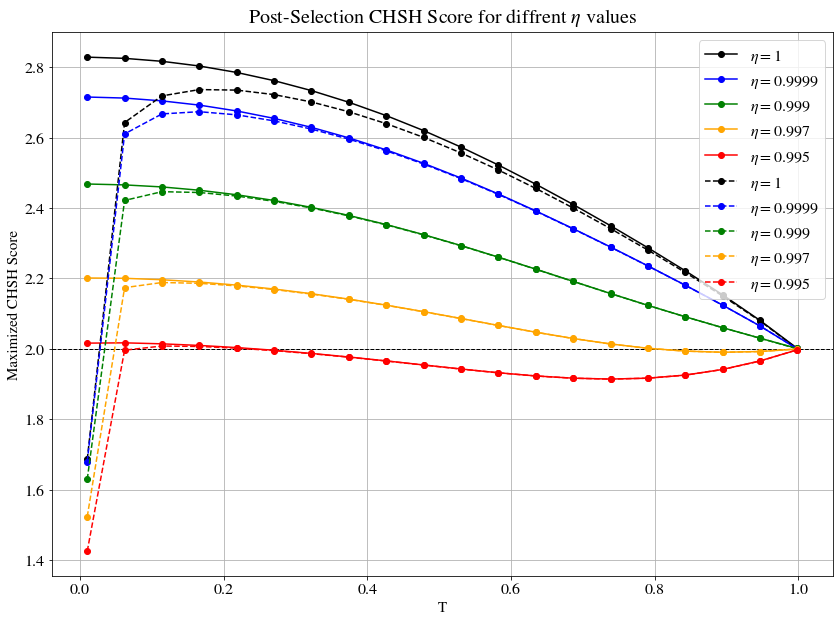

In [73]:
#optimized_scores_post_select[0] = ?

# Plot the result
import matplotlib


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...


fig, ax = plt.subplots(figsize=(14,10))

# Add dashed line at y=2
plt.axhline(y=2, color='k', linestyle='--', linewidth=1)


# Plots
plt.plot(T_values, corrected_1, marker='o', linestyle='-', color='k', label='$ \\eta = 1$')
plt.plot(T_values, corrected_9999, marker='o', linestyle='-', color='b', label='$ \\eta = 0.9999$')
plt.plot(T_values, corrected_999, marker='o', linestyle='-', color='g', label='$ \\eta = 0.999$')
plt.plot(T_values, corrected_997, marker='o', linestyle='-', color='orange', label='$ \\eta = 0.997$')
plt.plot(T_values, corrected_995, marker='o', linestyle='-', color='r', label='$ \\eta = 0.995$')


# Plots
plt.plot(T_values, corrected_1_dc_6, marker='o', linestyle='--', color='k', label='$ \\eta = 1$')
plt.plot(T_values, corrected_9999_dc_6, marker='o', linestyle='--', color='b', label='$ \\eta = 0.9999$')
plt.plot(T_values, corrected_999_dc_6, marker='o', linestyle='--', color='g', label='$ \\eta = 0.999$')
plt.plot(T_values, corrected_997_dc_6, marker='o', linestyle='--', color='orange', label='$ \\eta = 0.997$')
plt.plot(T_values, corrected_995_dc_6, marker='o', linestyle='--', color='r', label='$ \\eta = 0.995$')




plt.xlabel('T', size = 15)
plt.ylabel('Maximized CHSH Score', size = 15)
plt.title('eta = 0.9 ',  size = 20)
plt.title(f'Post-Selection CHSH Score for diffrent $\\eta$ values',  size = 20)
plt.legend(loc='best' ,prop={'size': 16})  # Add legend with automatic placement
plt.grid(True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


# Randomness

In [74]:
import numpy as np

def binary_entropy(p):
    """Compute the Shannon binary entropy function h(p)."""
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def randomness(S):
    if abs(S)<2:
        return 0
    """Compute the expression h((1 + sqrt((S/2)^2 - 1)) / 2)."""
    inner_term = (S / 2)**2 - 1
    if inner_term < 0:
        raise ValueError("Inner term (S/2)^2 - 1 must be non-negative.")
    
    value = (1 + np.sqrt(inner_term)) / 2
    return 1-binary_entropy(value)


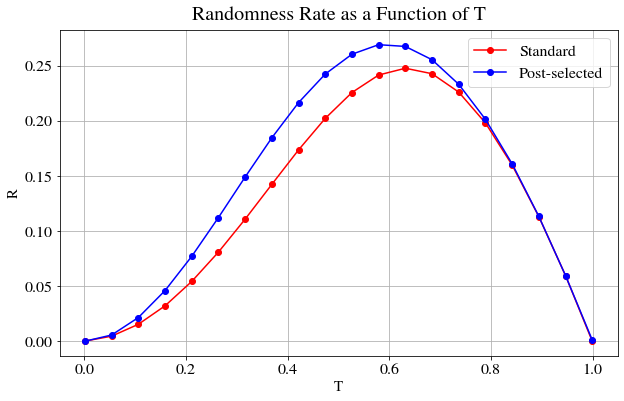

In [75]:
randomness_standard = [randomness(S) for S in optimized_scores]
randomness_post_select = []



T_values = np.linspace(0.001, 0.999, grid)

for i in range(20):
    T = T_values[i]
    mm = M_2x2_parametrized([0, 0, T ])
    S = optimized_scores_post_select[i]
    r = randomness(S)*(1-p(0,0,0,0,mm))
    randomness_post_select.append(r)

# Plotting the results

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(T_values, randomness_standard, marker='o', linestyle='-', label="Standard", color='red')
plt.plot(T_values, randomness_post_select, marker='o', linestyle='-', label="Post-selected", color='blue')
plt.xlabel("T", size = 15)
plt.ylabel("R", size = 15)
plt.title("Randomness Rate as a Function of T",  size = 20)
plt.grid(True)
plt.legend(loc='best' ,prop={'size': 16})  # Add legend with automatic placement
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


In [ ]:
## bebin in balaye hamin payini ro mide vase eta va p_dc? man copy kardam code ziro 

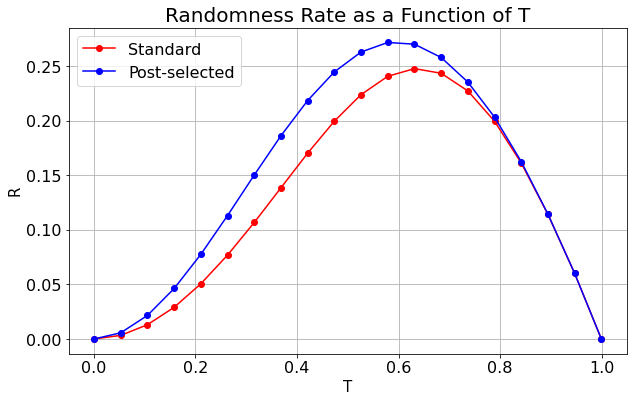

In [38]:
randomness_standard = [randomness(S) for S in optimized_scores]
randomness_post_select = []



T_values = np.linspace(0.001, 0.999, grid)

for i in range(20):
    T = T_values[i]
    mm = M_2x2_parametrized([0, 0, T ])
    S = optimized_scores_post_select[i]
    r = randomness(S)*(1-p(0,0,0,0,mm))
    randomness_post_select.append(r)

# Plotting the results

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(T_values, randomness_standard, marker='o', linestyle='-', label="Standard", color='red')
plt.plot(T_values, randomness_post_select, marker='o', linestyle='-', label="Post-selected", color='blue')
plt.xlabel("T", size = 15)
plt.ylabel("R", size = 15)
plt.title("Randomness Rate as a Function of T",  size = 20)
plt.grid(True)
plt.legend(loc='best' ,prop={'size': 16})  # Add legend with automatic placement
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


In [39]:
fig.savefig('Randomness_Bell.pdf', bbox_inches='tight')

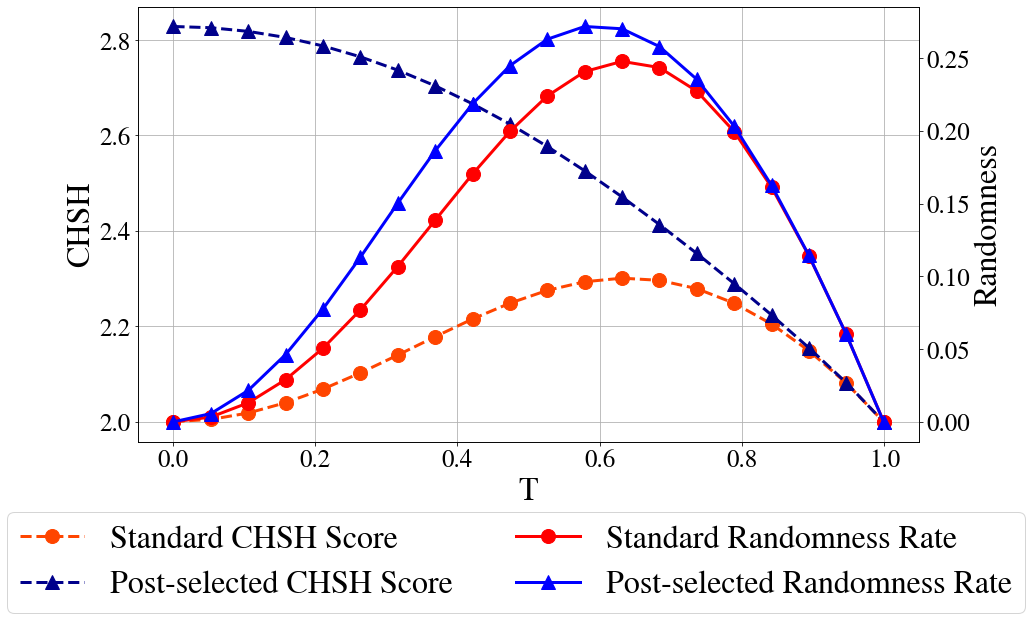

In [58]:
#plt.style.use('seaborn-dark-palette')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...







import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 8))
ax = plt.subplot(111)

# Plot S values on the primary y-axis

ax1.plot(T_values, optimized_scores,marker='o', markersize=14, linestyle='--', color='orangered', label='Standard CHSH Score',linewidth=3.0)
ax1.plot(T_values, optimized_scores_post_select,marker='^', markersize=14, linestyle='--', color='darkblue', label='Post-selected CHSH Score',linewidth=3.0)
ax1.set_xlabel("T", size=32)
ax1.set_ylabel("CHSH", size=32)
ax1.tick_params(axis='y')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
ax1.grid(True)

# Secondary y-axis for R values
ax2 = ax1.twinx()
ax2.plot(T_values, randomness_standard,marker='o', markersize=14, linestyle='-', label="Standard Randomness Rate", color='r',linewidth=3.0)
ax2.plot(T_values, randomness_post_select,marker='^', markersize=14, linestyle='-', label="Post-selected Randomness Rate", color='b',linewidth=3.0)

ax2.set_ylabel("Randomness", size=32)
ax2.tick_params(axis='y')

# Combined legend
#fig.legend(loc='upper right', prop={'size': 12})
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, prop={'size': 32})


# Title and formatting
#plt.title("Randomness Rate/CHSH Score as a Function of T", size=20)
#plt.xticks(fontsize=16)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()


In [59]:
fig.savefig('SPDC_plot_marker2.pdf', bbox_inches='tight')